In [1]:
import pandas as pd
import numpy as np
from numpy.random import seed
import keras
import random as rn
import tensorflow
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from keras.models import Sequential
from keras.layers import Dense
from sklearn.pipeline import Pipeline
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns  
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neural_network import MLPClassifier
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
import warnings
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import mutual_info_classif
warnings.filterwarnings('ignore')
rn.seed(66)
np.random.seed(66)
tensorflow.random.set_seed(66)
random_state = 66

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
raw_data = pd.read_csv('xAPI-Edu-Data.csv')
raw_data.head()

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,15,16,2,20,Yes,Good,Under-7,M
1,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,20,20,3,25,Yes,Good,Under-7,M
2,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,10,7,0,30,No,Bad,Above-7,L
3,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,30,25,5,35,No,Bad,Above-7,L
4,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,40,50,12,50,No,Bad,Above-7,M


### Data preprocessing
#### Magnitude features 
<font color='red'>Ordering makes sense</font> 

- raisehands
- VisITedResources
- AnnouncementsView
- Discussion

#### Categorical
<font color='red'>No ordering</font>
- StudentAbsenceDays
- gender
- ParentsAnsweringSurvey
- ParentsSchoolSatisfaction
- Nationality

Everything else can be mapped back using index

In [4]:
 ''' summarizes the shape of the input and output components.'''
def preprocess_data(df):
    nationality_columns = ['Egypt', 'Iran', 'Iraq', 'Jordan', 'KW', 'Lybia', 'Morocco', 'Palestine', 
                           'SaudiArabia', 'Syria', 'Tunis', 'USA', 'lebanon', 'venzuela']
    nationality_columns = ['Nationality_'+s for s in nationality_columns]
    processed_data = pd.DataFrame()
    processed_data[['AbsenceDays>7','AbsenceDays<7']] = pd.get_dummies(raw_data.StudentAbsenceDays)
    processed_data[['RaisedHands','VisITedResources']] = df[['raisedhands','VisITedResources']]
    processed_data[['AnnouncementsView','Discussion']] = df[['AnnouncementsView','Discussion']]
    processed_data[['Gender_F','Gender_M']] = pd.get_dummies(df.gender)
    processed_data[["Parent_Father","Parent_Mom"]] = pd.get_dummies(df.Relation)
    processed_data[['ParentAnsweringSurvey_No','ParentAnsweringSurvey_Yes']] = pd.get_dummies(df.ParentAnsweringSurvey)
    processed_data[['ParentschoolSatisfaction_Bad','ParentschoolSatisfaction_Good']] = pd.get_dummies(df.ParentschoolSatisfaction)
    processed_data[nationality_columns] =  pd.get_dummies(df.NationalITy)
    labels_map = {'L':0,'M':1,'H':2}
    df = df.drop(columns=['StudentAbsenceDays'])
    labels = raw_data['Class'].apply(lambda x:labels_map[x])
    return processed_data,labels

### Feature Scaling 
Only for numerical features

In [5]:
''' scaling params '''
def scaling_params(x):
  magnitude_features =  ["RaisedHands",
                      "VisITedResources","AnnouncementsView",
                      "Discussion"]
  categorical_features = [c for c in x.columns if not c in magnitude_features ]
  min_vect = x[magnitude_features].min(axis=0)
  reducer = x[magnitude_features].max(axis=0)-x[magnitude_features].min(axis=0)
  return min_vect,reducer

''' scale train and test using train params '''
def scale(x_train):
    magnitude_features =  ["RaisedHands",
                      "VisITedResources","AnnouncementsView",
                      "Discussion"]
    categorical_features = [c for c in x_train.columns if not c in magnitude_features ]
    min_vect,scaler = scaling_params(x_train)
    x_train_n = (x_train[magnitude_features]-min_vect)/(scaler)
    x_train_n[categorical_features] = x_train[categorical_features]
    # x_test_n = (x_test[magnitude_features]-min_vect)/(scaler)
    # x_test_n[magnitude_features] = (x_test[magnitude_features]-min_vect)/scaler
    # x_test_n[categorical_features] = x_test[categorical_features]
    return x_train_n

In [6]:
X, y = preprocess_data(raw_data)

### Baseline Models

#### $k$NN

In [7]:
''' knn grid with grid search + euclidean distance'''
def train_knn(x,y,k=10):
  grid = np.arange(1,25,2)
  grid_times = []
  grid_scores = []
  max_score = -1
  for i in range(len(grid)):
    clf = KNeighborsClassifier(n_neighbors=grid[i],metric='euclidean',weights='distance')
    scores = cross_validate(clf, x, y,scoring='precision_macro', cv=k,return_estimator=True)
    fit_times = scores['fit_time']
    test_scores = scores['test_score']
    if np.mean(test_scores)>max_score:
      max_score = np.mean(test_scores)
      grid_times = fit_times
      grid_scores = test_scores
      optimal_k = grid[i]
      estimators = scores['estimator']
  return {'k':optimal_k,'fit_times':grid_times,'test_scores':grid_scores,'estimators':estimators}

### Random Forest

In [8]:
def train_rf(x,y,k=10):
  grid = np.arange(10,120,10)
  grid_times = []
  grid_scores = []
  max_score = -1
  for i in range(len(grid)):
    clf = RandomForestClassifier(max_depth=10, random_state=random_state,n_estimators=grid[i],criterion='entropy')
    scores = cross_validate(clf, x, y,scoring='precision_macro', cv=k,return_estimator=True)
    fit_times = scores['fit_time']
    test_scores = scores['test_score']
    if np.mean(test_scores)>max_score:
      max_score = np.mean(test_scores)
      grid_times = fit_times
      grid_scores = test_scores
      optimal_estimators = grid[i]
      estimators = scores['estimator']
  return {'n_estimators':optimal_estimators,'fit_times':grid_times,'test_scores':grid_scores,'estimators':estimators}


### Support Vector Machine

In [9]:
def train_svc(x,y,k=10):
  grid = np.arange(1,7,0.5)
  grid_times = []
  grid_scores = []
  max_score = -1
  for i in range(len(grid)):
    clf = SVC(kernel='rbf',random_state=random_state,gamma=0.1,C=grid[i],tol=1e-6)
    scores = cross_validate(clf, x, y,scoring='precision_macro', cv=k,return_estimator=True)
    fit_times = scores['fit_time']
    test_scores = scores['test_score']
    if np.mean(test_scores)>max_score:
      max_score = np.mean(test_scores)
      grid_times = fit_times
      grid_scores = test_scores
      optimal_c = grid[i]
      estimators = scores['estimator']
  return {'C':optimal_c,'fit_times':grid_times,'test_scores':grid_scores,'estimators':estimators}


### MLP

In [10]:
def train_mlp(x,y,k=10):
  grid = [(3),(3,3),(28,3)]
  grid_times = []
  grid_scores = []
  max_score = -1
  for i in range(len(grid)):
    clf = MLPClassifier(solver='adam', max_iter=300, activation='tanh',learning_rate_init=0.1,learning_rate='constant',
                     hidden_layer_sizes=grid[i], random_state=random_state,verbose=False)
    scores = cross_validate(clf, x, y,scoring='precision_macro', cv=k,return_estimator=True)
    fit_times = scores['fit_time']
    test_scores = scores['test_score']
    if np.mean(test_scores)>max_score:
      max_score = np.mean(test_scores)
      grid_times = fit_times
      grid_scores = test_scores
      architecture = grid[i]
      estimators = scores['estimator']
  return {'architecture':architecture,'fit_times':grid_times,'test_scores':grid_scores,'estimators':estimators}


CNN

In [11]:
def create_model(architecture,input=28):
  convolution, dense = architecture
  model = models.Sequential()
  model.add(layers.Conv1D(convolution, 1, activation='tanh',input_shape=(input,1),kernel_initializer=keras.initializers.glorot_uniform(seed=66)))
  model.add(layers.Flatten())
  model.add(layers.Dense(dense, activation='softmax',kernel_initializer=keras.initializers.glorot_uniform(seed=66)))
  model.add(layers.Dense(3,kernel_initializer=keras.initializers.glorot_uniform(seed=66)))
  opt=tensorflow.keras.optimizers.Nadam(learning_rate=0.01, beta_1=0.6)
  model.compile(optimizer=opt,
    loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
  return model

def train_cnn(x,y,k=10):
  grid = [(1,3),(28,1),(3,3),(28,3)]
  grid_times = []
  grid_scores = []
  max_score = -1
  for i in range(len(grid)):
    clf = KerasClassifier(build_fn=create_model,architecture=grid[i] ,epochs=20, batch_size=10, verbose=0)
    scores = cross_validate(clf, x.values[:,:,None], y,scoring='precision_macro', cv=k,return_estimator=True)
    fit_times = scores['fit_time']
    test_scores = scores['test_score']
    if np.mean(test_scores)>max_score:
      max_score = np.mean(test_scores)
      grid_times = fit_times
      grid_scores = test_scores
      architecture = grid[i]
      estimators = scores['estimator']
  return {'architecture':architecture,'fit_times':grid_times,'test_scores':grid_scores,'estimators':estimators}

In [12]:
X_n = scale(X)
knn_config = train_knn(X_n,y)
k = knn_config['k']
print('k:',k)
print(np.mean(knn_config['test_scores']))

k: 15
0.7505613716414272


In [13]:
rf_config = train_rf(X_n,y)
n_estimators = rf_config['n_estimators'] 
print('n_estimators:',n_estimators)
print(np.mean(rf_config['test_scores']))

n_estimators: 50
0.7707883652868173


In [14]:
svc_config = train_svc(X_n,y)
C = svc_config['C']
print('C:',C)
print(np.mean(svc_config['test_scores']))

C: 1.0
0.7727240977976272


In [15]:
mlp_config = train_mlp(X_n,y)
mlp_architecture = mlp_config['architecture']
print("architecture:",mlp_architecture)
print(np.mean(mlp_config['test_scores']))

architecture: (3, 3)
0.7264434346089919


In [16]:
cnn_config = train_cnn(X_n,y) 
cnn_architecture = cnn_config['architecture']
np.mean(cnn_config['test_scores'])

0.7411164886071221

### Feature Selection
- Using information gain based method.
- Variances also checked

In [17]:
def gain_selection(x_norm):
  features=np.array([feature for feature in x_norm.columns])
  information_gain=mutual_info_classif(x_norm, y,n_neighbors=3,random_state=random_state)
  idx=np.argsort(information_gain)[::-1]
  information_gain=information_gain[idx]
  features=features[idx]
  return features,information_gain

def variance_selection(x_norm):
  x_var = x_norm.var()
  features = x_var.index
  variances = x_var.values
  idx = np.argsort(variances)[::-1]
  features = features[idx]
  variances = variances[idx]
  return features,variances

In [18]:
g_features,gains = gain_selection(X_n)
for i in range(len(g_features)):
  f = g_features[i]
  g = gains[i]
  print(f,":",g)

VisITedResources : 0.2885131581056892
AbsenceDays<7 : 0.28848284032564786
RaisedHands : 0.28313134293796316
AbsenceDays>7 : 0.2693129461777177
AnnouncementsView : 0.19131106703578316
ParentAnsweringSurvey_No : 0.1309873727016373
Parent_Mom : 0.09966770859780327
Discussion : 0.09764345175140265
ParentAnsweringSurvey_Yes : 0.08698969245659183
ParentschoolSatisfaction_Good : 0.07052810528528686
Nationality_Iran : 0.059971924415115785
ParentschoolSatisfaction_Bad : 0.05596549208371937
Parent_Father : 0.050432149353419886
Gender_M : 0.03780079908945888
Nationality_Lybia : 0.036691472662145674
Nationality_Palestine : 0.036454256577837185
Nationality_KW : 0.03566743664384964
Nationality_lebanon : 0.032176222848044445
Nationality_Iraq : 0.029950652237674236
Gender_F : 0.028064835516673048
Nationality_Tunis : 0.02722497179937089
Nationality_SaudiArabia : 0.004500254858140096
Nationality_Jordan : 0.0005544065387765862
Nationality_Morocco : 0.0
Nationality_Syria : 0.0
Nationality_Egypt : 0.0
Nati

In [19]:
v_features,variances = variance_selection(X_n)
for i in range(len(v_features)):
  f = v_features[i]
  v = variances[i]
  print(f,":",v)

ParentAnsweringSurvey_No : 0.24660751565762004
ParentAnsweringSurvey_Yes : 0.24660751565762004
Parent_Father : 0.24247999304105766
Parent_Mom : 0.24247999304105766
AbsenceDays>7 : 0.2400791579679889
AbsenceDays<7 : 0.2400791579679889
ParentschoolSatisfaction_Good : 0.2387613082811413
ParentschoolSatisfaction_Bad : 0.2387613082811413
Nationality_KW : 0.23433803061934583
Gender_F : 0.2321459638135004
Gender_M : 0.2321459638135004
Nationality_Jordan : 0.23041057759220593
VisITedResources : 0.11165052986938333
RaisedHands : 0.09473605427974961
Discussion : 0.07953398563634904
AnnouncementsView : 0.07373576755379414
Nationality_Palestine : 0.05504523312456506
Nationality_Iraq : 0.04382393876130829
Nationality_lebanon : 0.034233646485734175
Nationality_Tunis : 0.0244258872651357
Nationality_SaudiArabia : 0.022438239387613086
Nationality_Egypt : 0.018436847599164925
Nationality_Syria : 0.014400661099512876
Nationality_USA : 0.012369519832985386
Nationality_Iran : 0.012369519832985384
National

### SVM (Feature Pruning)

In [20]:
def eval_feature_subset(x,y,k_v=10):
    clf = SVC(kernel='rbf',random_state=random_state,gamma=0.1,C=1,tol=1e-6)
    scores = cross_validate(clf, x, y,scoring='precision_macro', cv=k_v,return_estimator=True)
    fit_times = scores['fit_time']
    test_scores = scores['test_score']
    acc = np.mean(test_scores)
    std = np.std(test_scores)
    avg_time = np.mean(fit_times)
    stats = {'no_features':len(x.columns),'acc':acc,'std':std,'time':avg_time}
    return stats

def best_feature_subset(x,y,features):
  x_n_pruned = X_n[(features[:1])]
  stats = eval_feature_subset(x_n_pruned,y)
  acc = []
  times = []
  for i in range(1,len(features)):
    x_n_pruned = X_n[(features[:i])]
    stats = eval_feature_subset(x_n_pruned,y)
    curr_acc = stats['acc']
    acc.append(curr_acc)
    times.append(stats['time'])
  idx = np.argmax(acc)
  features_subset = features[:idx+1]
  peak_acc = acc[idx] 
  time = times[idx]
  return features_subset,peak_acc,time

def eliminated_features(features,features_subset):
  return set(features)-set(features_subset)

In [21]:
features_subset,peak_acc,time = best_feature_subset(X_n,y,v_features)
print(peak_acc)

0.7750791305959678


### Features Retained

In [22]:
print(features_subset)

Index(['ParentAnsweringSurvey_No', 'ParentAnsweringSurvey_Yes',
       'Parent_Father', 'Parent_Mom', 'AbsenceDays>7', 'AbsenceDays<7',
       'ParentschoolSatisfaction_Good', 'ParentschoolSatisfaction_Bad',
       'Nationality_KW', 'Gender_F', 'Gender_M', 'Nationality_Jordan',
       'VisITedResources', 'RaisedHands', 'Discussion', 'AnnouncementsView',
       'Nationality_Palestine', 'Nationality_Iraq'],
      dtype='object')


### Features Eliminated

In [23]:
features_eliminated = eliminated_features(X_n.columns,features_subset)
for f in features_eliminated:
  print(f)

Nationality_lebanon
Nationality_Tunis
Nationality_USA
Nationality_venzuela
Nationality_Iran
Nationality_SaudiArabia
Nationality_Lybia
Nationality_Syria
Nationality_Morocco
Nationality_Egypt


### Model Evaluation On Pruned Feature Set

In [24]:
def eval_model(x,y,clf,kv=10):
    scores = cross_validate(clf, x, y,scoring='precision_macro', cv=kv,return_estimator=True)
    fit_times = scores['fit_time']
    test_scores = scores['test_score']
    acc = np.mean(test_scores)
    std = np.std(test_scores)
    avg_time = np.mean(fit_times)
    stats = {'no_features':x.shape[1],'acc':acc,'std':std,'time':avg_time}
    return stats



from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [25]:
X_n_p = X_n[features_subset]

### We now continuosly add features with accordance to their mutual gain until model performance starts to flattern out in order to get cut off point.

Number of features kept: 14
Number of features: removed 10
Accuracy: 0.71 (+/- 0.06)


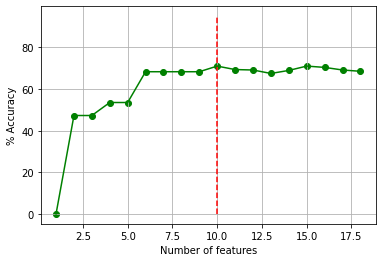

In [26]:
number_of_features=np.arange(1,len(features_subset)+1)
accuracy=np.zeros(len(features_subset))
std=np.zeros(len(features_subset))

for i in range(1,len(features_subset)):
    x_norm_pruned=X_n[(features_subset[:i])]
    support_vector_machine = SVC(kernel="rbf",C=6)
    support_vector_machine.fit(x_norm_pruned, y)
    scores = cross_validate(support_vector_machine, x_norm_pruned, y, scoring="accuracy",cv=10)
    accuracy[i]=scores["test_score"].mean()
    std[i]=scores["test_score"].std()
    
index=np.argsort(accuracy)
print("Number of features kept:",index[-1])
print("Number of features: removed",len(features_eliminated))
print("Accuracy: %0.2f (+/- %0.2f)" % (accuracy[index[-1]],std[-1]))
plt.figure()
plt.grid(True)
# plt.rc('xtick',labelsize=8)
# plt.rc('ytick',labelsize=8)
plt.xlabel("Number of features")
plt.ylabel("% Accuracy")

plt.scatter(number_of_features,accuracy*100,c="green")
plt.plot(number_of_features,accuracy*100,c="green")
plt.vlines(x=10,ymin=0,ymax=95,linestyles="dashed",color="red")
plt.savefig("accuracy_graph.png")
plt.show()

In [27]:
knn = KNeighborsClassifier(n_neighbors=k,metric='euclidean',weights='distance')
knn_stats = eval_model(X_n_p,y,knn)
print(knn_stats)

{'no_features': 18, 'acc': 0.7573729725001883, 'std': 0.07461550642297399, 'time': 0.0041360616683959964}


In [28]:
rf = RandomForestClassifier(max_depth=10, random_state=random_state,n_estimators=n_estimators)
rf_stats = eval_model(X_n_p,y,rf)
print(rf_stats)

{'no_features': 18, 'acc': 0.7736414752719101, 'std': 0.04836741927940704, 'time': 0.08950738906860352}


In [29]:
svc = SVC(kernel='rbf',random_state=random_state,gamma=0.1,C=1)
svc_stats = eval_model(X_n_p,y,svc)
print(svc_stats)

{'no_features': 18, 'acc': 0.7750791305959678, 'std': 0.051954274712056076, 'time': 0.010969209671020507}


In [30]:
mlp = MLPClassifier(solver='adam', max_iter=300, activation='tanh',learning_rate_init=0.1,learning_rate='constant',
                     hidden_layer_sizes=mlp_architecture, random_state=random_state,verbose=False)
mlp_stats = eval_model(X_n_p,y,mlp)
print(mlp_stats)

{'no_features': 18, 'acc': 0.7373361571003558, 'std': 0.08500590905484995, 'time': 0.10609197616577148}


In [31]:
cnn = KerasClassifier(build_fn=create_model,architecture=cnn_architecture,input=X_n_p.shape[1] ,epochs=20, batch_size=10, verbose=0)
cnn_stats = eval_model(X_n_p.values[:,:,None],y,cnn)

In [32]:
print(cnn_stats)

{'no_features': 18, 'acc': 0.7257798295365321, 'std': 0.0953070183192008, 'time': 2.106942367553711}


#### Model Evaluation

In [33]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

In [34]:
def numeric_metrics(model):
    scores = cross_validate(model, X_n_p, y, scoring=["accuracy","precision_macro","recall_macro"],cv=10)
    accuracy_mean,accuracy_std=(scores["test_accuracy"].mean()*100,100*scores["test_accuracy"].std())
    recall_mean,recall_std=(scores["test_recall_macro"].mean()*100,100*scores["test_recall_macro"].std())
    precision_mean,precision_std=(scores["test_precision_macro"].mean()*100,100*scores["test_precision_macro"].std())
    print("Accuracy: %0.2f (+/- %0.2f)" % (accuracy_mean,accuracy_std))
    print("Recall: %0.2f (+/- %0.2f)" % (recall_mean,recall_std))
    print("Precision: %0.2f (+/- %0.2f)" % (precision_mean,precision_std))
    print("Fitting time :",scores["fit_time"].mean())
    
def visual_metrics(model,name):
    names = ['L','M','H']
    y_predict=cross_val_predict(model,X_n_p,y,cv=10)
    multiclass_confusion_matrix=confusion_matrix(y,y_predict)
    plt.figure(figsize=(10,10))
    plt.rc('xtick',labelsize=17)
    plt.rc('ytick',labelsize=17)
    ax= plt.subplot()
    sns.heatmap(multiclass_confusion_matrix, annot=True, ax = ax,fmt='g',
                annot_kws={"size": 20})
    ax.set_xlabel('Classified',size=18)
    ax.set_ylabel('True',size=18) 
    ax.xaxis.set_ticklabels([n for n in names]) 
    ax.yaxis.set_ticklabels([n for n in names])
    # plt.savefig(name+".png",cmap="gray")
    plt.show()

Accuracy: 69.58 (+/- 8.08)
Recall: 69.57 (+/- 8.43)
Precision: 73.73 (+/- 8.50)
Fitting time : 0.10111610889434815


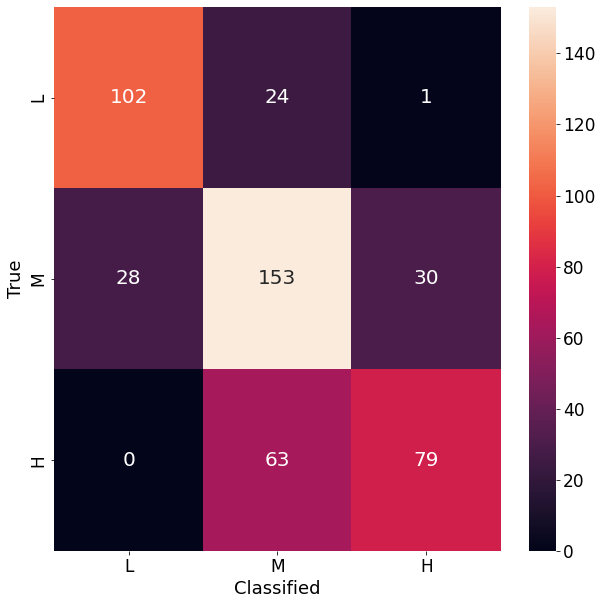

In [35]:
numeric_metrics(mlp)
visual_metrics(mlp, 'mlp')

Accuracy: 72.50 (+/- 7.67)
Recall: 74.97 (+/- 5.64)
Precision: 73.51 (+/- 7.99)
Fitting time : 2.2527509212493895


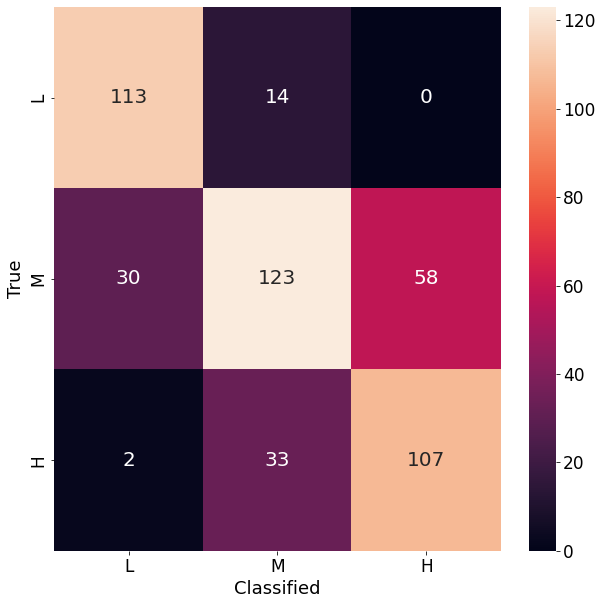

In [36]:
numeric_metrics(cnn)
visual_metrics(cnn,'cnn')

Accuracy: 75.21 (+/- 5.39)
Recall: 75.52 (+/- 5.53)
Precision: 77.36 (+/- 4.84)
Fitting time : 0.08595113754272461


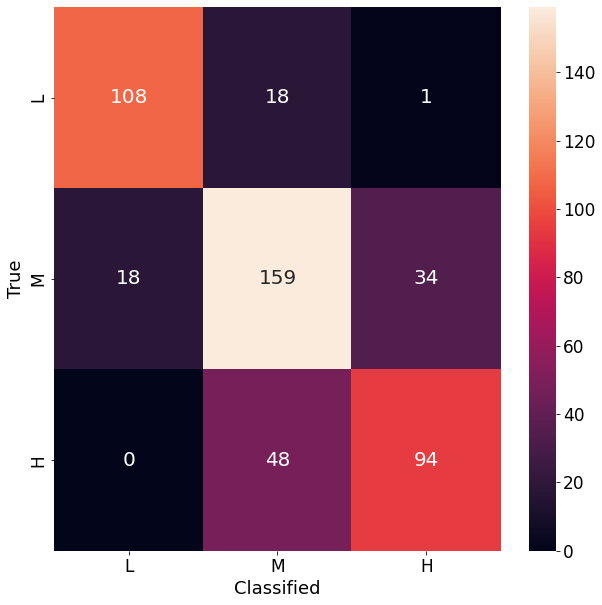

In [37]:
numeric_metrics(rf)
visual_metrics(rf,'rf')

Accuracy: 75.00 (+/- 5.67)
Recall: 75.78 (+/- 5.89)
Precision: 77.51 (+/- 5.20)
Fitting time : 0.01130361557006836


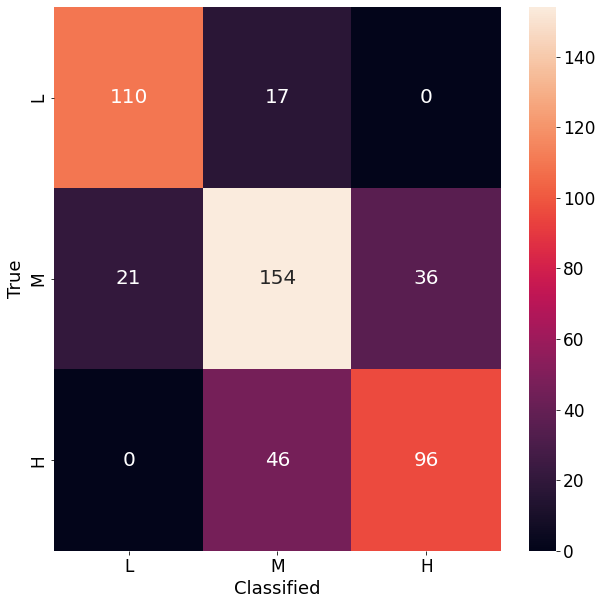

In [38]:
numeric_metrics(svc)
visual_metrics(svc,'svc')

### Analysis & Visuals

#### Factors Affecting Student Perfomance
 A few of features with high entropy
- VisITedResources : 0.2885131581056892
- AbsenceDays<7 : 0.28848284032564786
- RaisedHands : 0.28313134293796316
- AbsenceDays>7 : 0.2693129461777177
- AnnouncementsView : 0.19131106703578316
- ParentAnsweringSurvey_No : 0.1309873727016373
- Parent_Mom : 0.09966770859780327
- Discussion : 0.09764345175140265
- ParentAnsweringSurvey_Yes : 0.08698969245659183
- ParentschoolSatisfaction_Good : 0.07052810528528686


In [39]:
df = raw_data.copy()
order = {'L':0,'M':1,'H':2}
df['Order'] = df['Class'].apply(lambda x:order[x])
df = df.sort_values(by=['Order'])

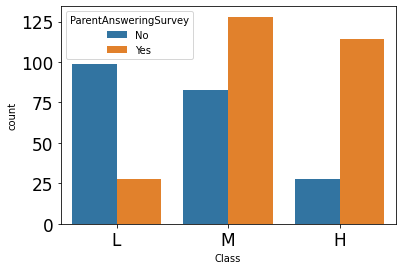

In [40]:
 sns.countplot(x="Class", hue="ParentAnsweringSurvey", data=df)

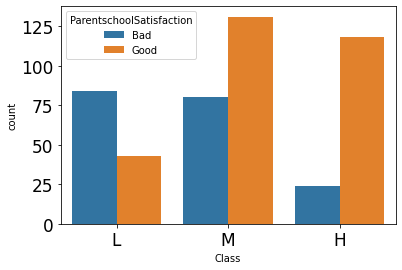

In [41]:
sns.countplot(x="Class", hue="ParentschoolSatisfaction", data=df)

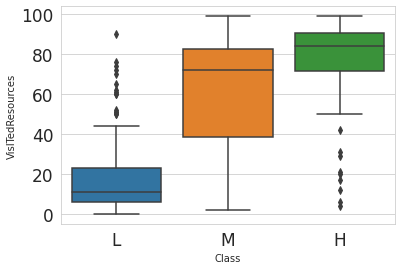

In [42]:
sns.set_style("whitegrid")
sns.boxplot(x = 'Class', y = 'VisITedResources', data = df)

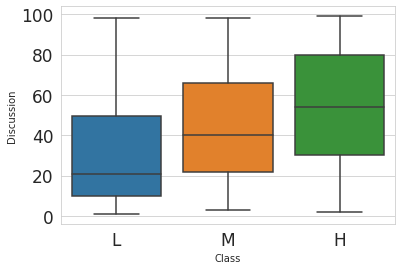

In [43]:
sns.set_style("whitegrid")
sns.boxplot(x = 'Class', y = 'Discussion', data = df)